# Day 4 - Feature Engineering + Random Forest Baseline
## Ernesto Gonzales, MSDA


Goal: 
Creating new features for tree models


In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
RocCurveDisplay, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Loading data from Seaborn

df = sns.load_dataset("titanic").copy()

In [4]:
# Basic feature selection

base_features = ["sex", "age", "fare", "class", "embarked", "sibsp", "parch", "alone"]
df_base = df[base_features + ["survived"]].copy()

In [5]:
# Feature Engineering
# family_size: total people with ticket in a family group (sib/sp + parch + self)
df_base["family_size"] = (df_base["sibsp"].fillna(0) + df_base["parch"].fillna(0) + 1).astype(int)

In [6]:
# is_child: creating an age cutoff (<16) to create category

df_base["is_child"] = (df_base["age"] < 16).astype("float")

In [7]:
# fare_per_person: dividing fare by family_size (clipping at 1)

df_base["fare_per_person"] = df_base["fare"] / df_base["family_size"].clip(lower=1)

In [9]:
# Feature Selection

features = ["sex", "class", "embarked", "alone", "age", "fare", "sibsp",
            "parch", "family_size", "is_child", "fare_per_person"]

X = df_base[features].copy()
y = df_base["survived"].copy()


In [10]:
# Addressing missing values 

X = X.dropna()
y = y.loc[X.index]

print("X shape:", X.shape, "| y shape:", y.shape) # printing shapes

display(X.head())

X shape: (712, 11) | y shape: (712,)


,sex,class,embarked,alone,age,fare,sibsp,parch,family_size,is_child,fare_per_person
0,male,Third,S,False,22.0,7.2500,1,0,2,0.0,3.62500
1,female,First,C,False,38.0,71.2833,1,0,2,0.0,35.64165
2,female,Third,S,True,26.0,7.9250,0,0,1,0.0,7.92500
3,female,First,S,False,35.0,53.1000,1,0,2,0.0,26.55000
4,male,Third,S,True,35.0,8.0500,0,0,1,0.0,8.05000


In [18]:
# Preprocessing
num_features = ["age", "fare", "sibsp", "parch", "family_size", "is_child", "fare_per_person"]
cat_features = ["sex", "class", "embarked", "alone"]

# Transforming and Scaling features

num_transformer = Pipeline(steps=[("scaler", StandardScaler())])

cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

# Column Transformer

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])



In [20]:
# Pipelines

# Logistic Regression
log_reg = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))])
# Decision Tree
dec_tree = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"))])

# Random Forest
rand_forest = Pipeline(steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier(n_estimators=200, max_depth=7,
                                                                                               random_state=42, class_weight="balanced"))])


In [21]:
# Cross-validation 

# Stratified 5-fold CV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  Creating a model dictionary
models = {"Logistic Regression": log_reg,
          "Decision Tree": dec_tree,
          "Random Forest": rand_forest}

results = []

for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    f1 = cross_val_score(model, X, y, cv=cv, scoring="f1")
    roc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")

    results.append({
        "Model": name,
        "Accuracy (mean)": acc.mean(),
        "Accuracy (std)": acc.std(),
        "F1 (mean)": f1.mean(),
        "F1 (std)": f1.std(),
        "ROC-AUC (mean)": roc.mean(),
        "ROC-AUC (std)": roc.std()}) # appending CV scores on each model

cv_results = pd.DataFrame(results) # creating a table with the results list
cv_results

,Model,Accuracy (mean),Accuracy (std),F1 (mean),F1 (std),ROC-AUC (mean),ROC-AUC (std)
0,Logistic Regression,0.790633,0.035363,0.747228,0.037059,0.852805,0.038422
1,Decision Tree,0.807574,0.030420,0.760558,0.041539,0.840918,0.037156
2,Random Forest,0.824397,0.036812,0.776404,0.049215,0.872685,0.046990


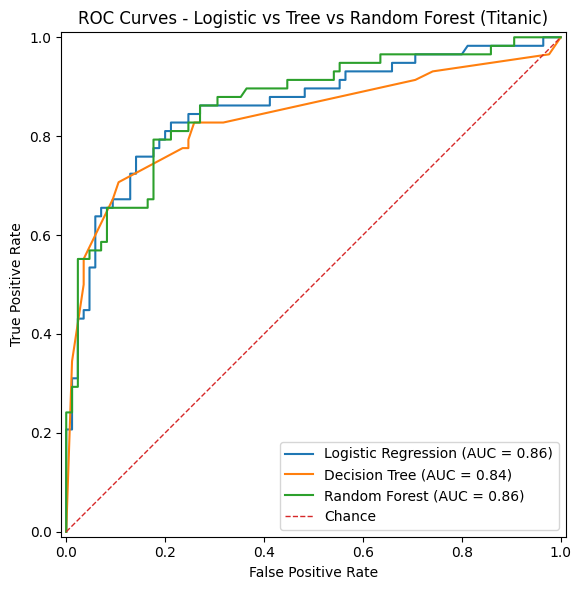

In [31]:
# ROC Curves for all 3 models

# Train test split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fitting each model pipeline with the training set

log_reg.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Plotting one figure with all 3 ROC curves

fig, ax = plt.subplots(figsize=(7,6))

RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(dec_tree, X_test, y_test, ax=ax, name="Decision Tree")
RocCurveDisplay.from_estimator(rand_forest, X_test, y_test, ax=ax, name="Random Forest")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Chance")
plt.title("ROC Curves - Logistic vs Tree vs Random Forest (Titanic)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()

# Saving plot
fig.savefig("../docs/titanic_day4_roc_overlay.png", dpi=150, bbox_inches="tight")

plt.show()